In [182]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json

def load_image(image_path, resize=True):
    # Load the image without resizing
    image = Image.open(image_path)
    if resize:
        image = image.resize((256, 256))  # Resize for model consistency
    return np.array(image) / 255.0  # Normalize and return image data


def load_labels_for_detection(json_path, img_width, img_height, num_boxes=20):
    labels = []
    if json_path:
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center = float(box['x']) + 7.5  # 15/2 to get center
                y_center = float(box['y']) + 7.5  # 15/2 to get center
                x_min = (x_center - 7.5) / img_width
                y_min = (y_center - 7.5) / img_height
                x_max = (x_center + 7.5) / img_width
                y_max = (y_center + 7.5) / img_height
                labels.append([x_min, y_min, x_max, y_max])
        # Pad labels if less than num_boxes
        while len(labels) < num_boxes:
            labels.append([0, 0, 0, 0])  # Padding with dummy coordinates
    return labels






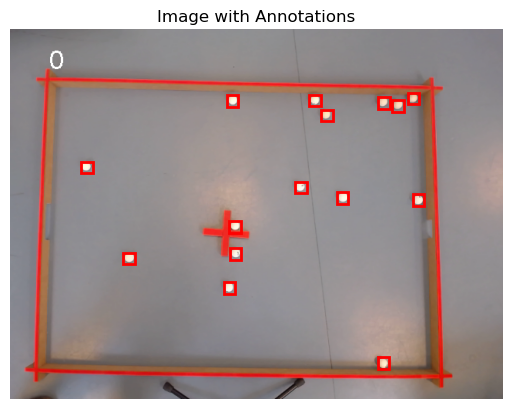

In [183]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

def display_image_with_annotations(image_path, json_path):
    # Load the image
    image = Image.open(image_path)
    # Assuming you want to work with the original size or resize as needed
    # image = image.resize((256, 256))  # Optional: Resize if required
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Load and draw annotations from JSON
    if json_path and os.path.exists(json_path):
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':  # Ensure we're only processing 'ball' annotations
                # Extract box information
                x_center = float(box['x'])
                y_center = float(box['y'])
                width = 15#float(box['width'])
                height = 15#float(box['height'])
                
                # Convert center coordinates to top-left corner, which is what matplotlib expects
                x = x_center - width / 2
                y = y_center - height / 2
                
                # Create a rectangle patch
                rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

    plt.title('Image with Annotations')
    plt.axis('off')  # Turn off axes for better visibility
    plt.show()

# Example usage
image_path = '../images/image_1.png'
json_path = '../json_labeling/label_1.json'
display_image_with_annotations(image_path, json_path)


In [184]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Reshape

def create_model(num_boxes=20, num_coords=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_boxes * num_coords, activation='sigmoid'),
        Reshape((num_boxes, num_coords))
    ])
    return model




In [185]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='mse',  # Mean Squared Error for bounding box regression
                  metrics=['mse', 'accuracy']) 

In [186]:
def data_generator(image_paths, json_paths, batch_size, num_boxes=20):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                image = load_image(image_paths[i])
                labels = load_labels_for_detection(json_paths[i], 256, 256, num_boxes)
                batch_images.append(image)
                batch_labels.append(labels)
            yield np.array(batch_images), np.array(batch_labels)

In [187]:
def train_model(model, train_gen, steps_per_epoch, epochs=10):
    history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs)
    return history


In [192]:

def load_labels_for_detection(json_path, img_width, img_height, num_boxes=20):
    labels = []
    if json_path:
        with open(json_path, 'r') as file:
            data = json.load(file)
        for box in data['boxes']:
            if box['label'] == 'ball':
                x_center = float(box['x']) + 7.5  # 15/2 to get center
                y_center = float(box['y']) + 7.5  # 15/2 to get center
                x_min = (x_center - 7.5) / img_width
                y_min = (y_center - 7.5) / img_height
                x_max = (x_center + 7.5) / img_width
                y_max = (y_center + 7.5) / img_height
                labels.append([x_min, y_min, x_max, y_max])
        while len(labels) < num_boxes:
            labels.append([0, 0, 0, 0])  # Padding with dummy coordinates
    return labels

def show_predictions(model, image_paths, json_paths, num_samples=5, num_boxes=20):
    fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples * 10))  # 2 columns for side by side display
    for i in range(num_samples):
        original_image = load_image(image_paths[i], resize=False)
        model_input_image = load_image(image_paths[i], resize=True)  # Resized for the model
        img_height, img_width, _ = original_image.shape  # Get the original image dimensions

        true_labels = load_labels_for_detection(json_paths[i], img_width, img_height)
        predicted_labels = model.predict(model_input_image[np.newaxis, ...])[0]

        # Display original image with true annotations
        axs[i, 0].imshow(original_image)
        axs[i, 0].set_title(f'Image {i+1} - Ground Truth')
        if os.path.exists(json_paths[i]):
            with open(json_paths[i], 'r') as file:
                data = json.load(file)
            for box in data['boxes']:
                if box['label'] == 'ball':
                    x_center = float(box['x'])
                    y_center = float(box['y'])
                    width = 15  # Assuming width of 15 for the ball
                    height = 15  # Assuming height of 15 for the ball
                    x = x_center - width / 2
                    y = y_center - height / 2
                    rect_true = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='g', facecolor='none')
                    axs[i, 0].add_patch(rect_true)

        # Display original image with predicted annotations
        axs[i, 1].imshow(original_image)
        axs[i, 1].set_title(f'Image {i+1} - Predictions')
        for pred in predicted_labels:
            center_x = pred[0] * 256
            center_y = pred[1] * 256
            width = (pred[2] - pred[0]) * 256
            height = (pred[3] - pred[1]) * 256
            top_left_x = center_x - width / 2
            top_left_y = center_y - height / 2
            rect_pred = patches.Rectangle((top_left_x, top_left_y),
                                          width,
                                          height, linewidth=2, edgecolor='r', facecolor='none')
            axs[i, 1].add_patch(rect_pred)

            # Print predicted coordinates for debugging
            print(f"Image {i+1} - Prediction {pred}: Center ({center_x:.2f}, {center_y:.2f}), Width: {width:.2f}, Height: {height:.2f}")

    plt.show()



Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.2706 - loss: 0.4866 - mse: 0.4866
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.1625 - loss: 0.2917 - mse: 0.2917
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0164 - loss: 0.2338 - mse: 0.2338  
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0495 - loss: 0.2585 - mse: 0.2585
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.0342 - loss: 0.2551 - mse: 0.2551
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.0420 - loss: 0.2742 - mse: 0.2742 
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.0784 - loss: 0.2134 - mse: 0.2134
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.1024 - loss: 0.2360 - mse: 0.2360
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.0842 - loss: 0.2566 - mse: 0.2566
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.0733 - loss: 0.2688 - mse: 0.2688 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


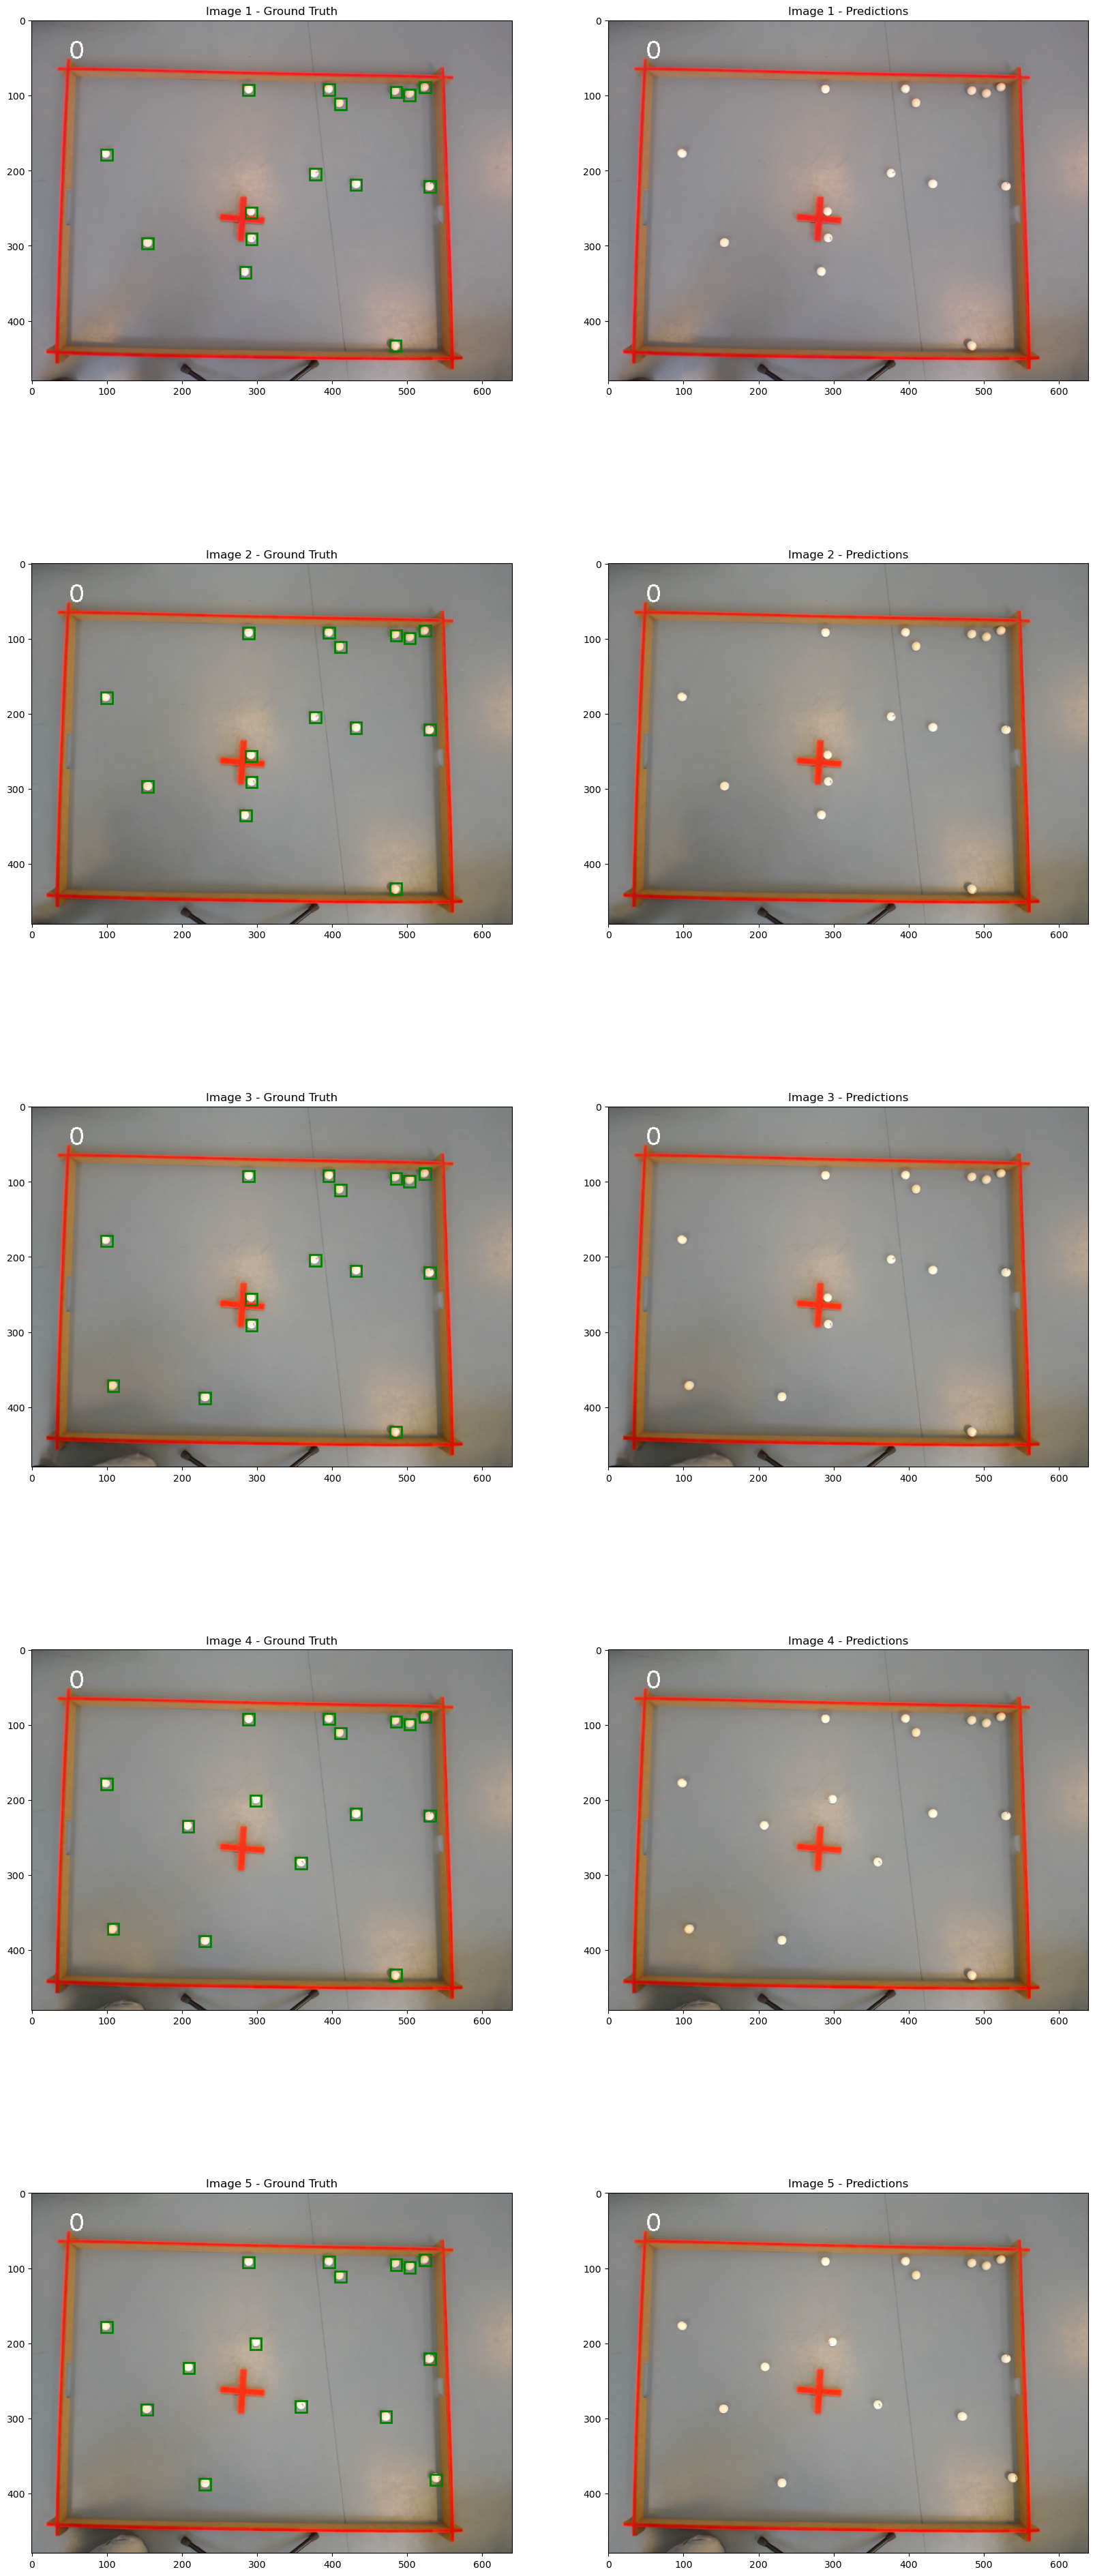

In [193]:
# Example usage
image_paths = [f'../images/image_{i}.png' for i in range(1, 100)]
json_paths = [f'../json_labeling/label_{i}.json' for i in range(1, 100)]

# Create and compile model
model = create_model()
compile_model(model)

# Create data generator and train model
batch_size = 32
train_gen = data_generator(image_paths, json_paths, batch_size)
history = train_model(model, train_gen, steps_per_epoch=len(image_paths) // batch_size, epochs=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Width: 0.00, Height: 0.00
Image 1 - Prediction [1.        1.        1.        0.9999649]: Center (256.00, 256.00), Width: 0.00, Height: -0.01
Image 1 - Prediction [1. 1. 1. 1.]: Center (256.00, 256.00), Wi

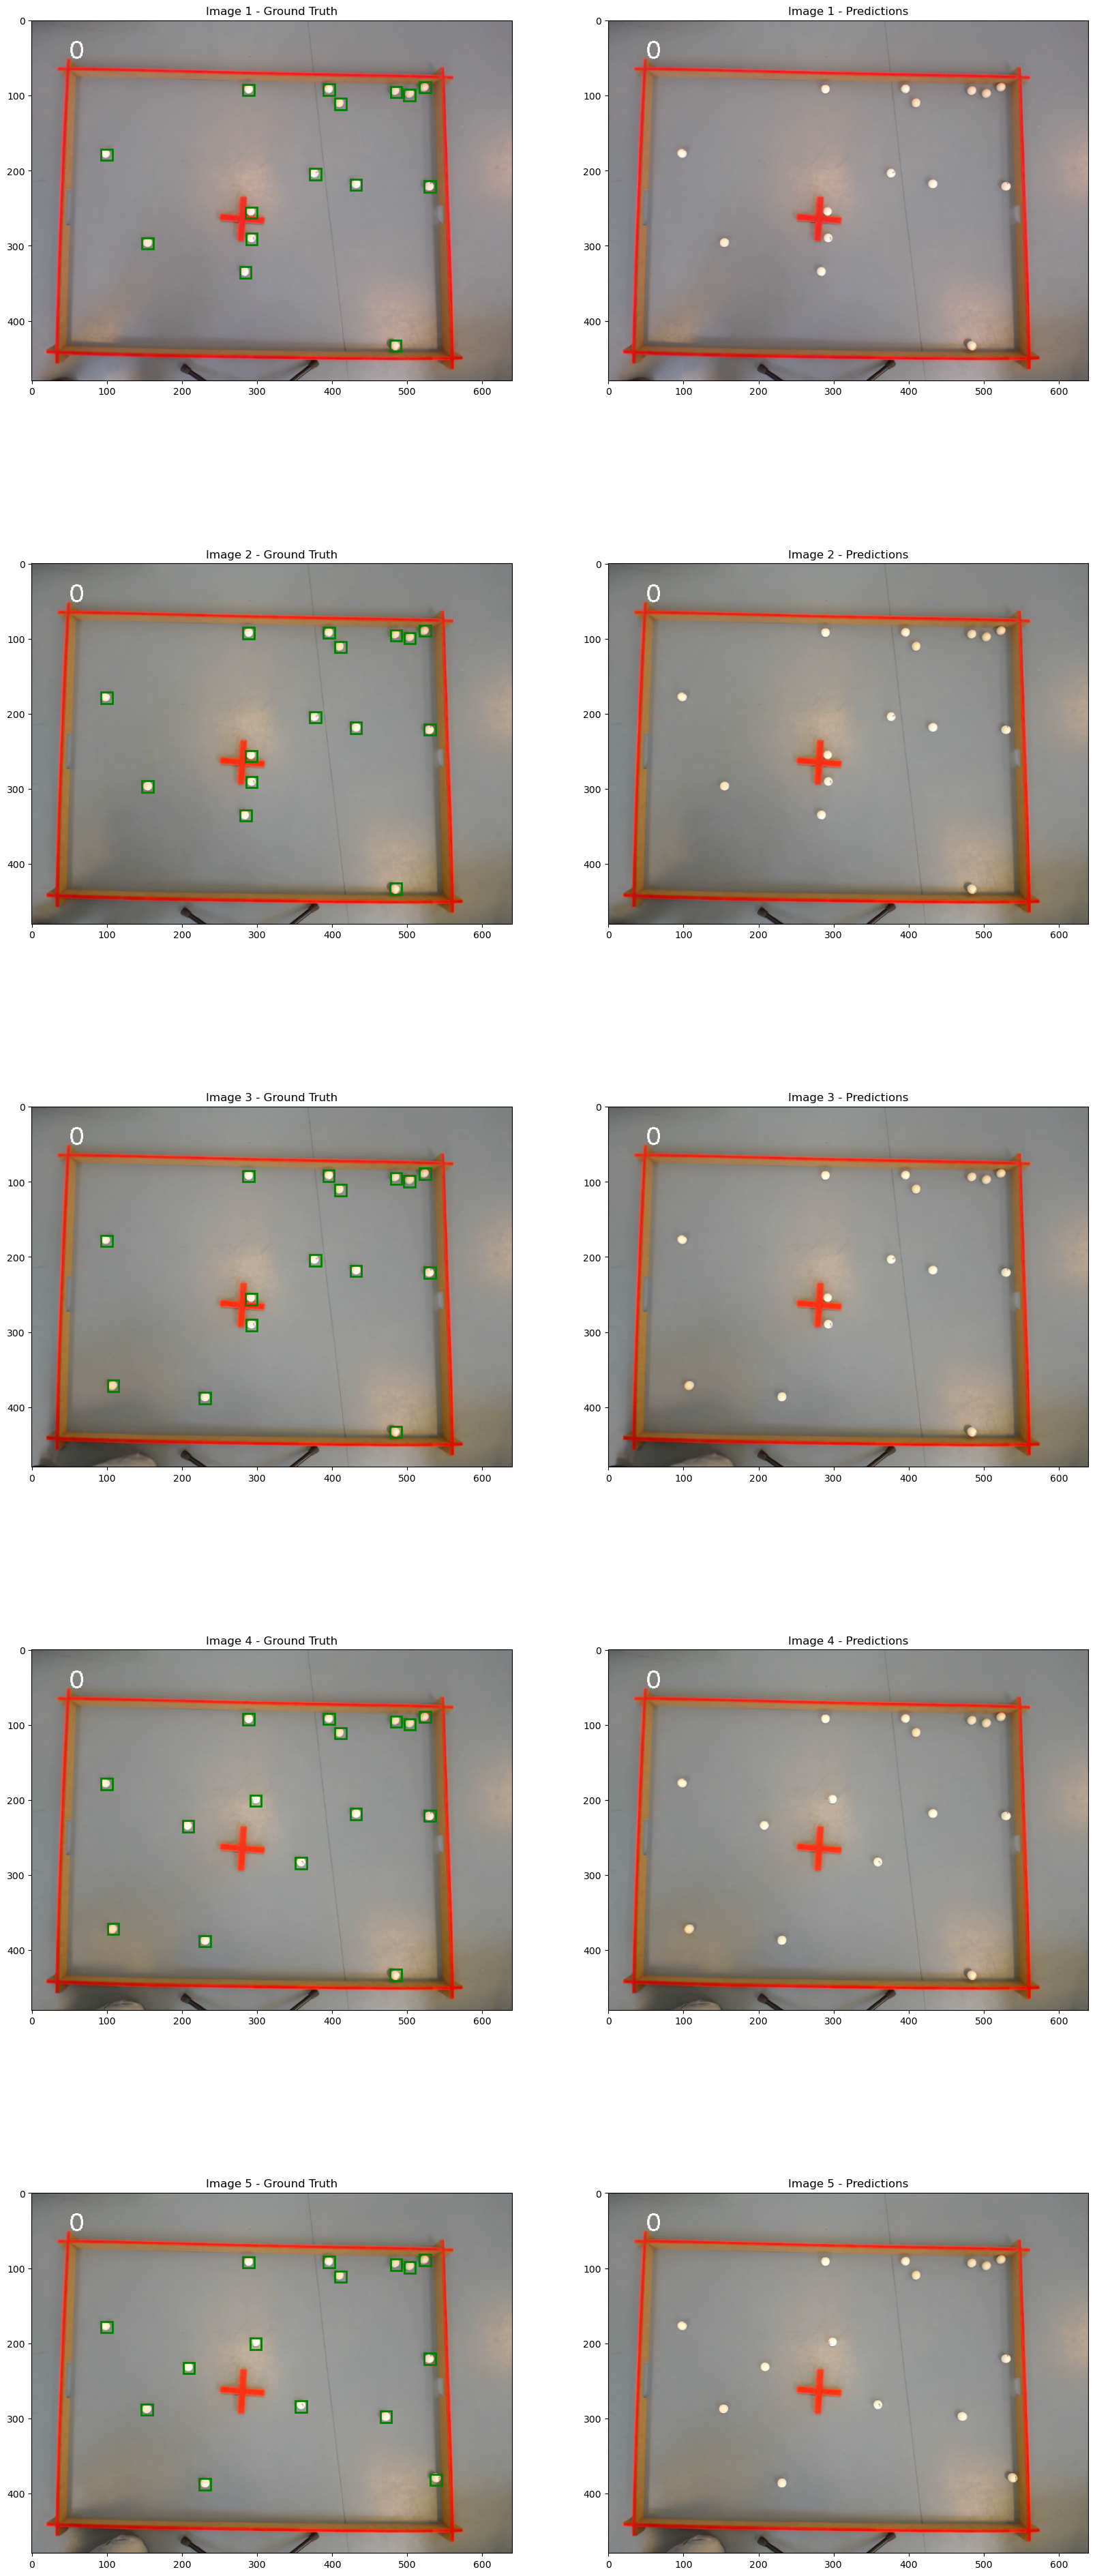

In [194]:
# Display predictions
show_predictions(model, image_paths, json_paths)

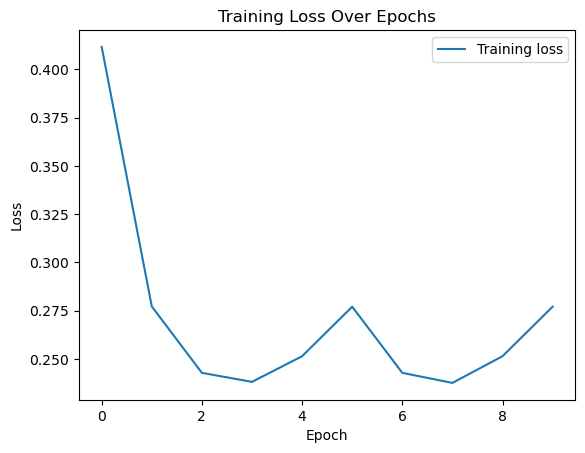

In [190]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call this function with your training history
plot_training_history(history)
